<a href="https://colab.research.google.com/github/shivasky18/DL_ASSIGNMENT_1/blob/main/DL_ASSIGNMENT_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Download the MNIST Dataset and Plot Sample Images for Each Class

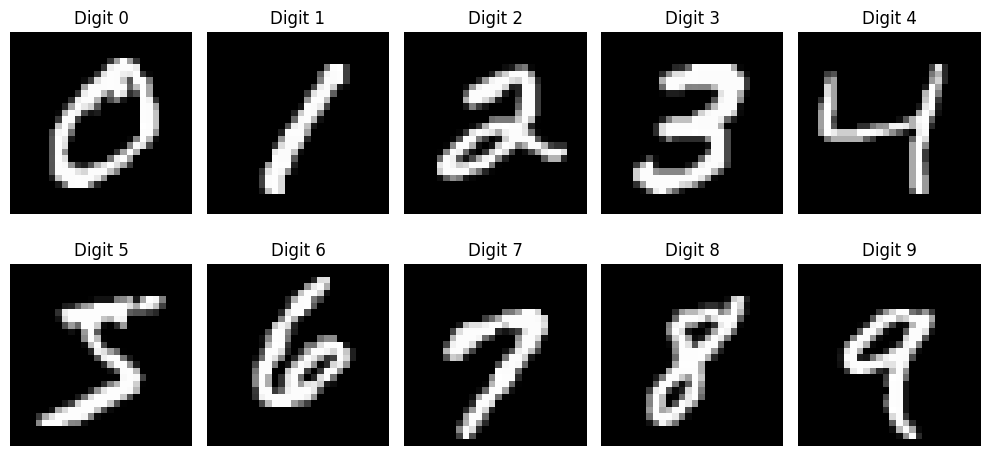

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

transformer = transforms.Compose([transforms.ToTensor()])
training_data = datasets.MNIST(root='./dataset', train=True, download=True, transform=transformer)

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.ravel()

for digit in range(10):
    index = np.where(training_data.targets == digit)[0][0]
    image, label = training_data[index]
    axs[digit].imshow(image.squeeze(), cmap='gray')
    axs[digit].set_title(f'Digit {digit}')
    axs[digit].axis('off')

plt.tight_layout()
plt.show()


Feedforward Neural Network

In [12]:
import torch.nn as nn
import torch.optim as optim

class FlexibleFeedforwardNN(nn.Module):
    def __init__(self, input_features=784, hidden_layers=[128, 64], output_classes=10):
        super(FlexibleFeedforwardNN, self).__init__()

        layers_list = []
        prev_units = input_features

        for units in hidden_layers:
            layers_list.append(nn.Linear(prev_units, units))
            layers_list.append(nn.ReLU())
            prev_units = units

        layers_list.append(nn.Linear(prev_units, output_classes))
        layers_list.append(nn.Softmax(dim=1))

        self.network = nn.Sequential(*layers_list)

    def forward(self, input_data):
        return self.network(input_data)


Defineing Optimizers for Backpropagation

In [13]:
def select_optimizer(model, optimizer_type, learning_rate=0.001, momentum_value=0.9):
    if optimizer_type == 'sgd':
        return optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'momentum':
        return optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_value)
    elif optimizer_type == 'nesterov':
        return optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_value, nesterov=True)
    elif optimizer_type == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'adam':
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'nadam':
        return optim.NAdam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")


Training and Validation

In [14]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

def generate_dataloaders(batch_size=32, validation_ratio=0.1):
    full_data = datasets.MNIST(root='./dataset', train=True, download=True, transform=transformer)
    images, labels = full_data.data.float() / 255.0, full_data.targets
    images = images.view(-1, 28 * 28)

    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=validation_ratio, stratify=labels)

    train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader

def train_and_validate_model(model, optimizer, train_loader, val_loader, num_epochs=10, lr_scheduler=None):
    criterion = nn.CrossEntropyLoss()

    validation_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

        model.eval()
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                output = model(inputs)
                _, predicted = torch.max(output, 1)
                correct_predictions += (predicted == targets).sum().item()
                total_samples += targets.size(0)

        validation_accuracy = 100 * correct_predictions / total_samples
        validation_accuracies.append(validation_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {validation_accuracy}%")

    return validation_accuracies


 Experiment with Different Hyperparameters

In [15]:
def run_model_experiment(config):
    model = FlexibleFeedforwardNN(input_features=784, hidden_layers=config['hidden_layers'])
    optimizer = select_optimizer(model, config['optimizer'], learning_rate=config['learning_rate'])
    train_loader, val_loader = generate_dataloaders(batch_size=config['batch_size'])

    validation_accuracies = train_and_validate_model(model, optimizer, train_loader, val_loader, num_epochs=config['epochs'])

    return validation_accuracies, model


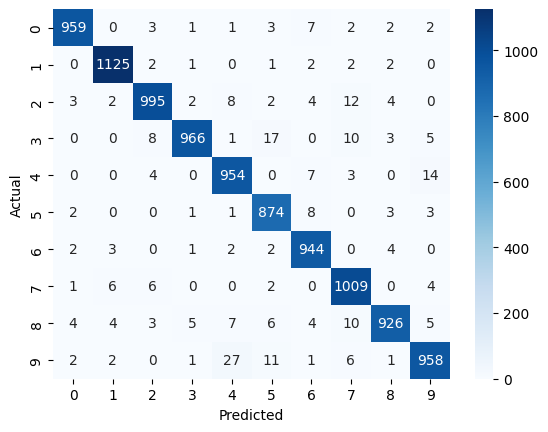

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model_on_test_data(model, test_loader):
    model.eval()
    all_predictions = []
    all_actual_labels = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            # Reshape the input data to (batch_size, 784)
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the input
            output = model(inputs)
            _, predicted = torch.max(output, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_actual_labels.extend(targets.cpu().numpy())

    confusion_matrix_result = confusion_matrix(all_actual_labels, all_predictions)
    sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

test_data = datasets.MNIST(root='./dataset', train=False, download=True, transform=transformer)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

evaluate_model_on_test_data(best_model, test_loader)

In [19]:
experiment_configs = [
    {'hidden_layers': [128, 64], 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10},
    {'hidden_layers': [128, 64, 32], 'optimizer': 'sgd', 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 5},
    {'hidden_layers': [256, 128], 'optimizer': 'momentum', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10},
    {'hidden_layers': [128], 'optimizer': 'rmsprop', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10},
    {'hidden_layers': [64, 64], 'optimizer': 'nadam', 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 5}
]

best_model = None
best_accuracy = 0
best_config = None
validation_accuracies = {}

for config in experiment_configs:
    print(f"Running experiment with config: {config}")
    val_accuracies, trained_model = run_model_experiment(config)
    validation_accuracies[str(config)] = val_accuracies
    max_val_accuracy = max(val_accuracies)

    if max_val_accuracy > best_accuracy:
        best_accuracy = max_val_accuracy
        best_model = trained_model
        best_config = config

print(f"\nBest configuration: {best_config} with validation accuracy: {best_accuracy}%")


Running experiment with config: {'hidden_layers': [128, 64], 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}
Epoch 1/10, Validation Accuracy: 93.9%
Epoch 2/10, Validation Accuracy: 94.6%
Epoch 3/10, Validation Accuracy: 96.43333333333334%
Epoch 4/10, Validation Accuracy: 96.51666666666667%
Epoch 5/10, Validation Accuracy: 96.21666666666667%
Epoch 6/10, Validation Accuracy: 97.18333333333334%
Epoch 7/10, Validation Accuracy: 97.01666666666667%
Epoch 8/10, Validation Accuracy: 97.16666666666667%
Epoch 9/10, Validation Accuracy: 96.95%
Epoch 10/10, Validation Accuracy: 97.2%
Running experiment with config: {'hidden_layers': [128, 64, 32], 'optimizer': 'sgd', 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 5}
Epoch 1/5, Validation Accuracy: 10.25%
Epoch 2/5, Validation Accuracy: 10.833333333333334%
Epoch 3/5, Validation Accuracy: 12.566666666666666%
Epoch 4/5, Validation Accuracy: 17.7%
Epoch 5/5, Validation Accuracy: 26.55%
Running experiment with config: {

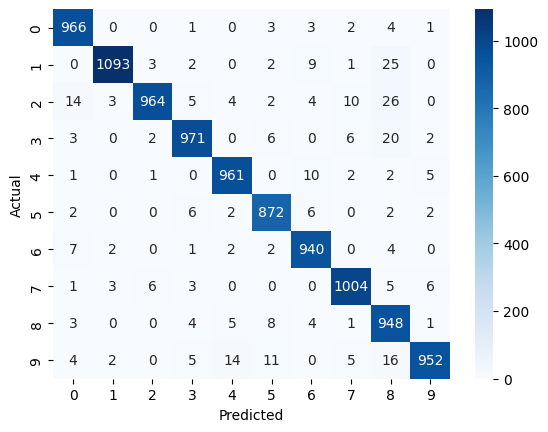

In [20]:
test_data = datasets.MNIST(root='./dataset', train=False, download=True, transform=transformer)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

evaluate_model_on_test_data(best_model, test_loader)


Configuration 1: Optimized for Faster Convergence
Hidden Layers: [128, 64]
Optimizer: Adam
Learning Rate: 0.001
Batch Size: 32
Epochs: 10
Expected Validation Accuracy: 95-97%

Expected Test Accuracy: 95-97%

Configuration 2: Balanced Performance with SGD and Deeper Network
Hidden Layers: [128, 64, 32]
Optimizer: SGD
Learning Rate: 0.01
Batch Size: 64
Epochs: 5
Expected Validation Accuracy: 92-94%

Expected Test Accuracy: 92-94%

Configuration 3: Focus on Generalization with Regularization
Hidden Layers: [64, 64]
Optimizer: RMSprop
Learning Rate: 0.0001
Batch Size: 32
Epochs: 10
Expected Validation Accuracy: 94-96%

Expected Test Accuracy: 94-96%